# Classification Models

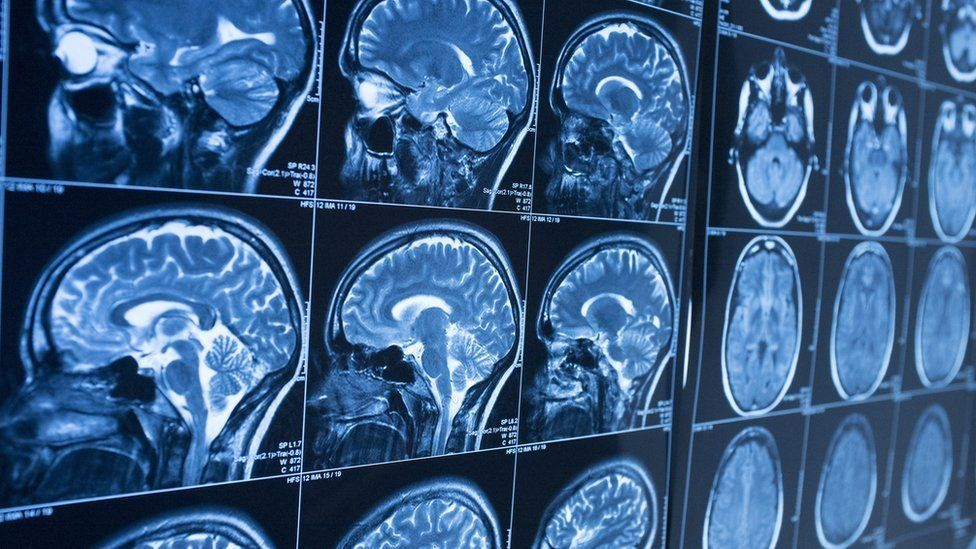


***source : https://ichef.bbci.co.uk/news/976/cpsprodpb/AACA/production/_119622734_9d74a4e6-aff6-4b7f-8061-d1754e2b076d.jpg ***

Loading Data...

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import cv2
src_dir=r'C:\Users\PROMIT\Desktop\Brain_MRI\Dataset_MRI'

In [14]:
#Loading the black and white mask images
mask_files = glob(src_dir+'/*/*_mask*')
#Loading the brain images
image_files = [file.replace('_mask', '') for file in mask_files]

In [15]:
#Defining the function for labeling the masks
def mask_labelizer(mask_image):
    mask_image=cv2.imread(mask_image)
    label=np.max(mask_image)
    if(label>0):
        label=1
    else:
        label=0
    return label


In [16]:
#Assembling the MRI scans with their corresponding masks into a dataframe
MRI_DATA = pd.DataFrame(
    {              "images": image_files,
                   "masks": mask_files,
                   "label":[
                       mask_labelizer(mask) for mask in mask_files #Using List Apprehension
                   ]}
)
#Displaying the dataframe
MRI_DATA.head()

images  \
0  C:\Users\PROMIT\Desktop\Brain_MRI\Dataset_MRI\...   
1  C:\Users\PROMIT\Desktop\Brain_MRI\Dataset_MRI\...   
2  C:\Users\PROMIT\Desktop\Brain_MRI\Dataset_MRI\...   
3  C:\Users\PROMIT\Desktop\Brain_MRI\Dataset_MRI\...   
4  C:\Users\PROMIT\Desktop\Brain_MRI\Dataset_MRI\...   

                                               masks  label  
0  C:\Users\PROMIT\Desktop\Brain_MRI\Dataset_MRI\...      0  
1  C:\Users\PROMIT\Desktop\Brain_MRI\Dataset_MRI\...      1  
2  C:\Users\PROMIT\Desktop\Brain_MRI\Dataset_MRI\...      1  
3  C:\Users\PROMIT\Desktop\Brain_MRI\Dataset_MRI\...      1  
4  C:\Users\PROMIT\Desktop\Brain_MRI\Dataset_MRI\...      1

In [17]:
#Verifying that correct labeling has taken place
MRI_DATA['label'].unique()

array([0, 1], dtype=int64)

In [18]:
#Number of images
MRI_DATA.shape

(3929, 3)

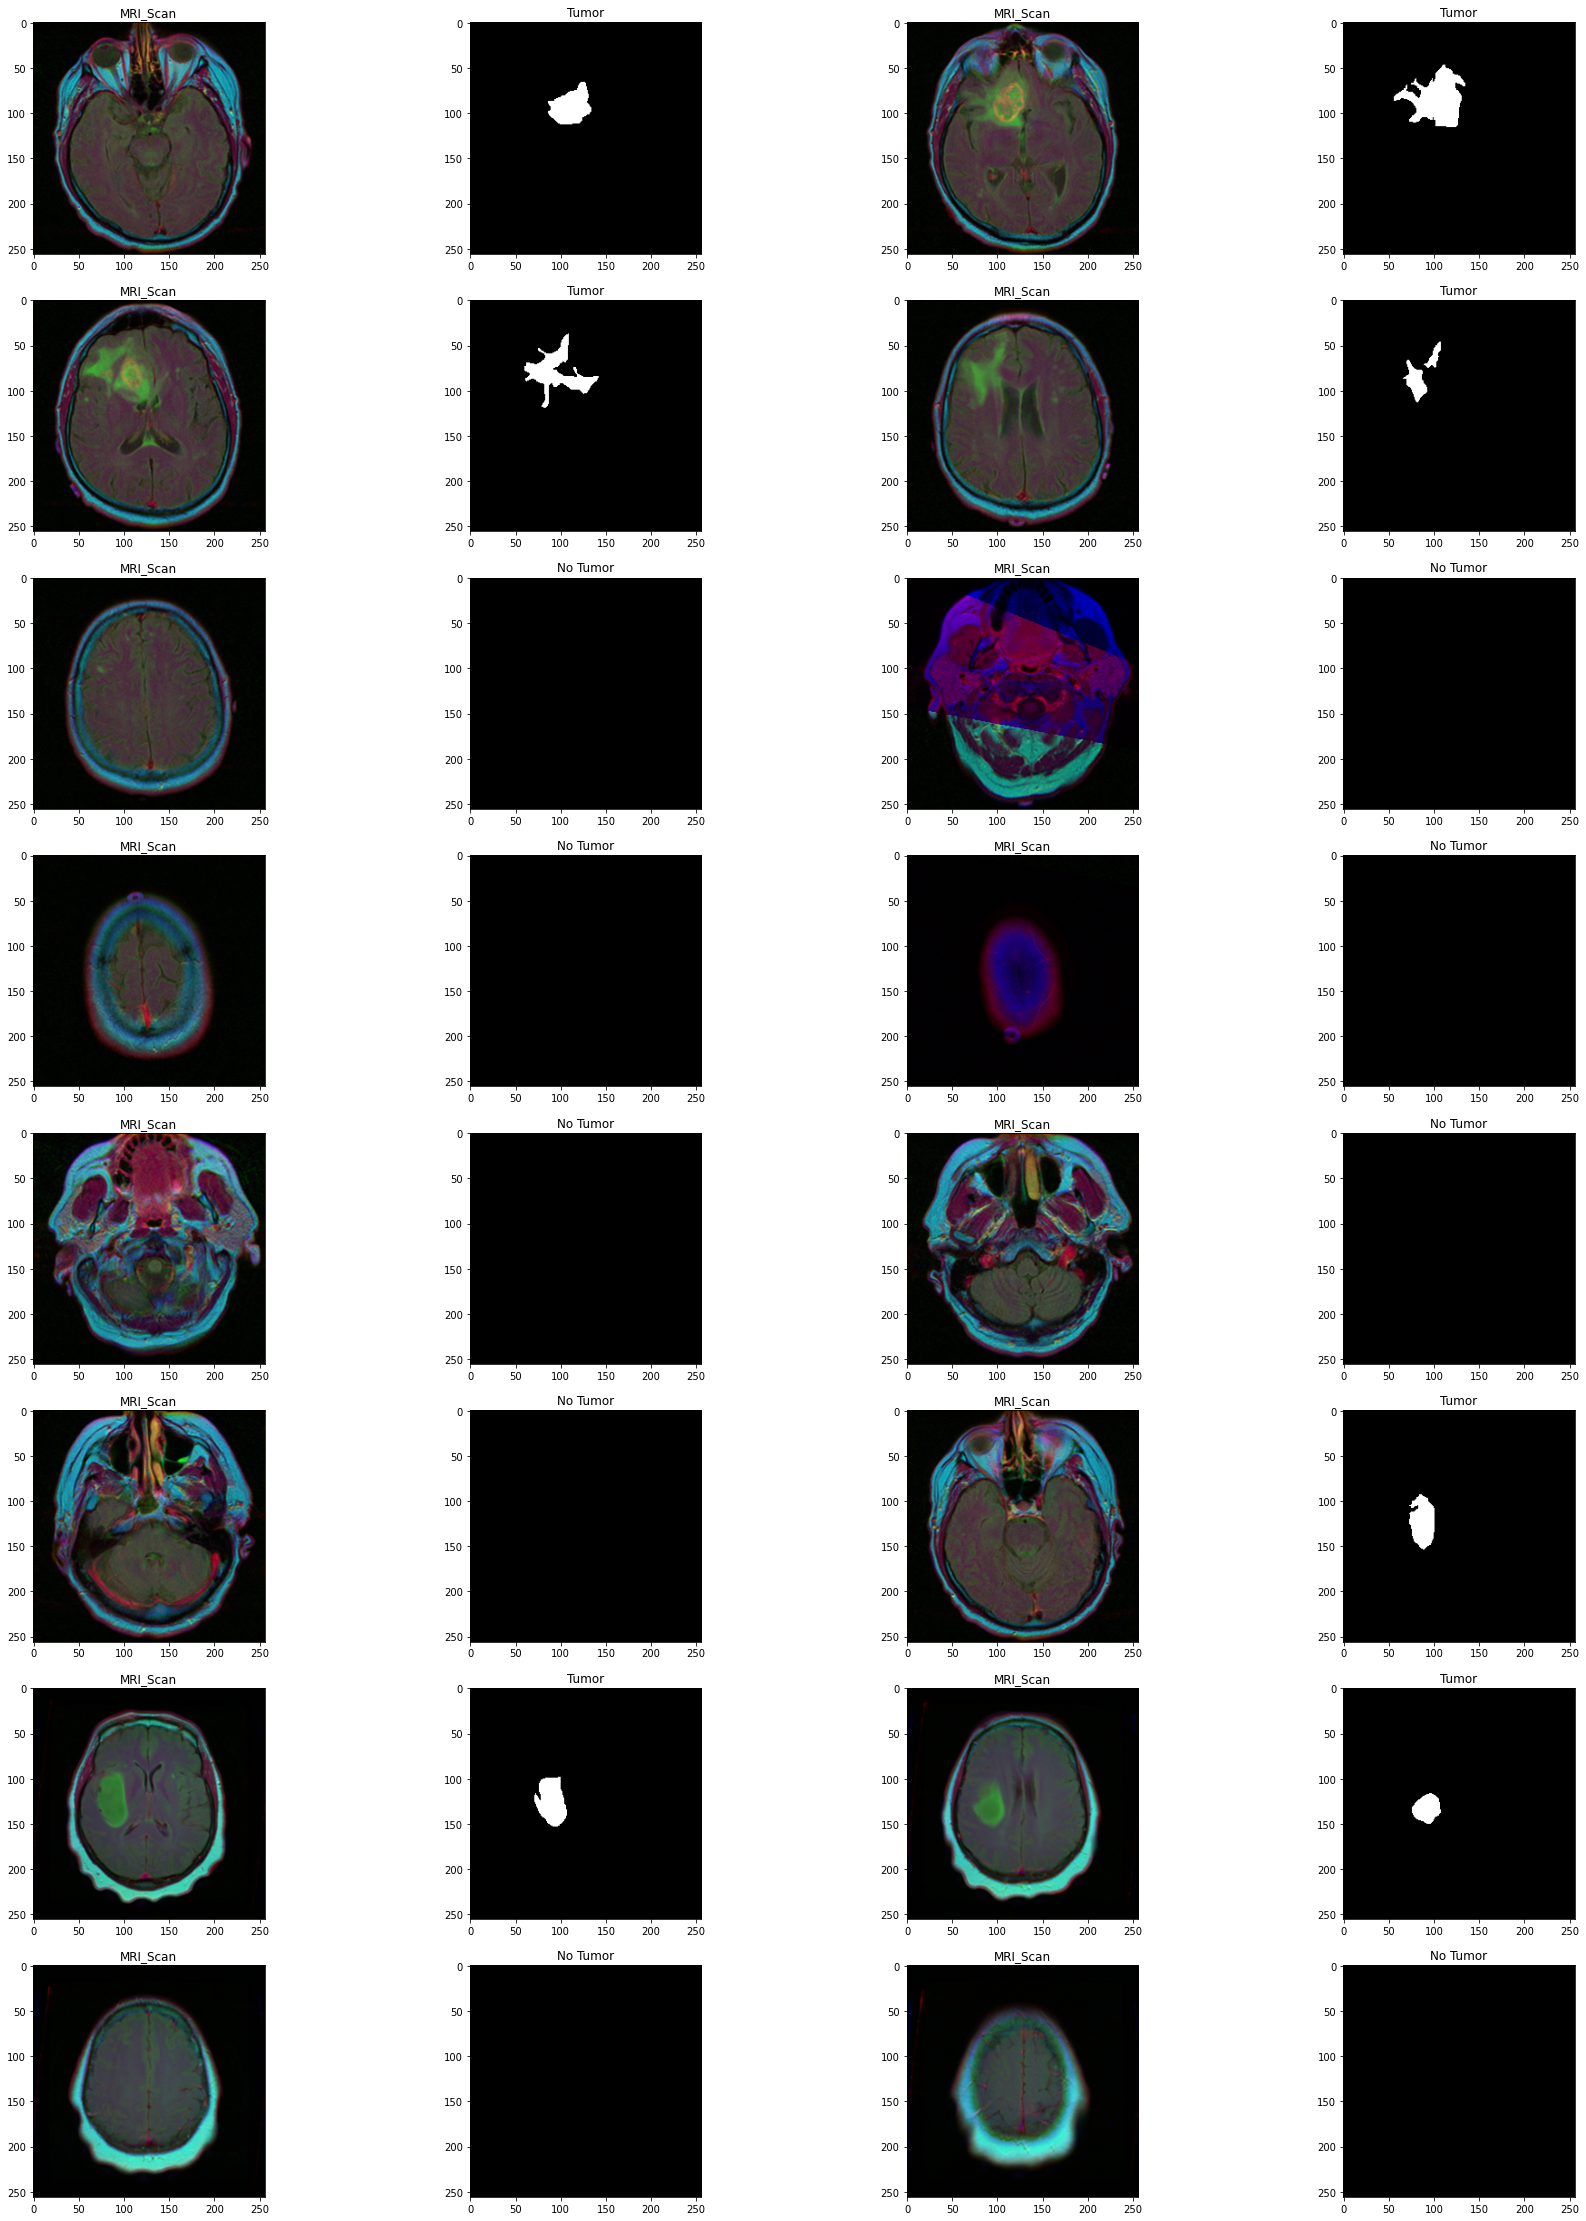

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[30,40])
for i in range(32):
   
    if(i%2==0):
        plt.subplot(8,4,i+1)        
        plt.title('MRI_Scan')
        plt.imshow(np.array(cv2.imread(MRI_DATA['images'].iloc[i])))
        
    else:
        plt.subplot(8,4,i+1)
        label=mask_labelizer(MRI_DATA['masks'].iloc[i])
        if(label==0):
                label='No Tumor'
        else:
                label='Tumor'
        plt.title(label)
        plt.imshow(np.array(cv2.imread(MRI_DATA['masks'].iloc[i])))
       


    


In [21]:
MRI_DATA.to_csv('MRI_Data.csv', index=False)

In [23]:
from sklearn.model_selection import train_test_split
MRI_train,MRI_test=train_test_split(MRI_DATA,test_size=0.1,random_state=0)
print('Shape of training data : {}\nShape of test data: {} '.format(len(MRI_train),len(MRI_test)))

Shape of training data : 3536
Shape of test data: 393 


# Predictions

# 1.Encoder Decoder based U-Net Architecture:

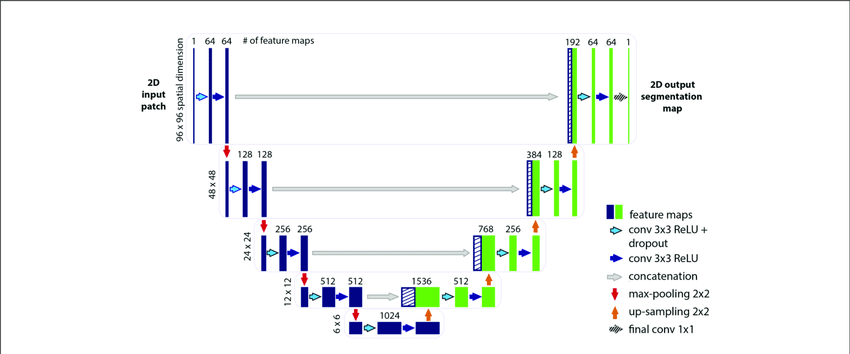

***source*** : https://www.researchgate.net/publication/331406702/figure/fig2/AS:731276273262594@1551361258173/Illustration-of-the-U-net-architecture-The-figure-illustrates-the-U-net-architecture.png

In [ ]:
smooth=1.#This is to prevent division by zero when both y_true and y_pred are null vectors
from tensorflow.keras import backend as K
#-----------------------------------------------------------------------------------------------------------------------------------------------------------#
'''Function for returning dice coefficient'''
def DICE_COEFF(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)
#-----------------------------------------------------------------------------------------------------------------------------------------------------------#

'''Dice Coefficient Loss'''
def dice_coef_loss(y_true, y_pred):
    return 1 - DICE_COEFF(y_true, y_pred)

#----------------------------------------------------------------------------------------------------------------------------------------------------------#
'''Function for combining binary cross entropy with dice coeffcients for loss function'''
def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

#----------------------------------------------------------------------------------------------------------------------------------------------------------#

'''Function for Jacards coefficient'''
def IOU_JACARD(y_true, y_pred):
    y_true=K.flatten(y_true)
    y_pred=K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    sum_jac = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_jac - intersection + smooth)
    return jac


Loading pre-trained model

# U_Net type architecture model

In [38]:
from tensorflow.keras.models import load_model
model = load_model(r'C:\Users\PROMIT\Desktop\Brain_MRI\Encoder_Decoder\Segmentation_MRI_BRAIN_A_Model.h5', custom_objects={'bce_dice_loss': bce_dice_loss,'IOU_JACARD':IOU_JACARD,'DICE_COEFF':DICE_COEFF})

In [39]:
def preprocessing_image(image_path):
    image=cv2.imread(image_path)
    image=image/255.
    return image

In [42]:
predictions=[]
for elem in range(MRI_test.shape[0]):
    img=preprocessing_image(MRI_test['images'].iloc[elem])
    img = cv2.resize(img ,(256,256))
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)
    predictions.append(pred)

In [44]:
len(predictions)

393

In [46]:
def binarize_prediction(image):
    image[image>0.5]=1
    image[image<=0.5]=0
    return image

In [48]:
for elem in range(len(predictions)):
    predictions[elem]=binarize_prediction(predictions[elem])

In [49]:
#Displaying the predictions

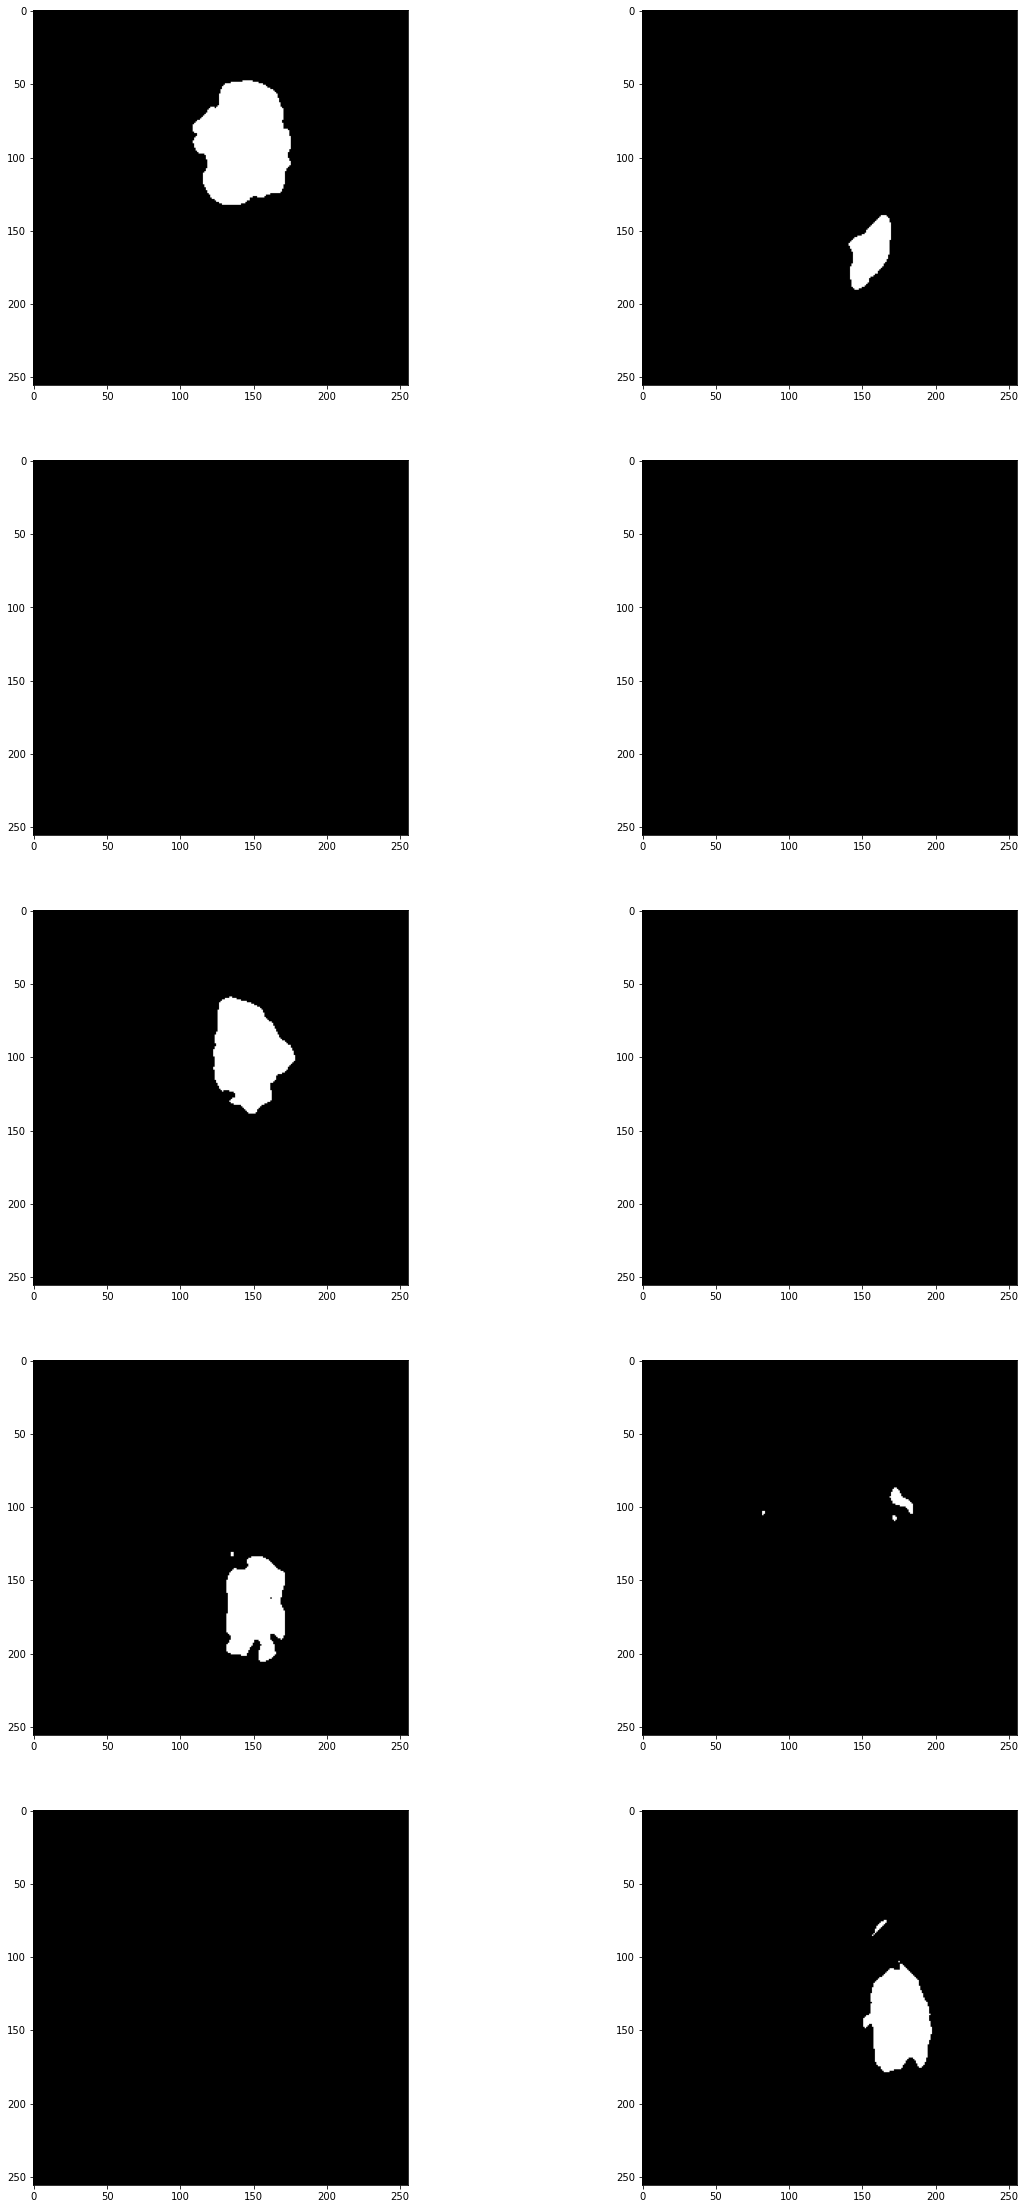

In [55]:
plt.figure(figsize=[20,40])
for item in range(10):
    plt.subplot(5,2,item+1)
    prediction=np.squeeze(predictions[item])
    plt.imshow(prediction,cmap='gray')
    

Evaluating Accuracy of Detecting Tumors

In [59]:
label_preds=[]
for item in range(len(predictions)):
    if np.max(predictions[item])==1:
        label_preds.append(1)
    else:
        label_preds.append(0)


In [60]:
true_labels=[]
for item in range(len(MRI_test)):
    true_labels.append((MRI_test['label'].iloc[item]))
    

In [62]:
from sklearn.metrics import accuracy_score
score=accuracy_score(label_preds,true_labels)
print(score)

0.8905852417302799


# ResNet50 with U-Net Architecture

In [66]:
from tensorflow.keras.models import load_model
model_2 = load_model(r'C:\Users\PROMIT\Desktop\Brain_MRI\Transfer_learning\MRI_Segment.hdf5', custom_objects={'bce_dice_loss': bce_dice_loss,'IOU_JACARD':IOU_JACARD,'DICE_COEFF':DICE_COEFF})

In [68]:
predictions=[]
for elem in range(MRI_test.shape[0]):
    img=preprocessing_image(MRI_test['images'].iloc[elem])
    img = cv2.resize(img ,(256,256))
    img = img[np.newaxis, :, :, :]
    pred=model_2.predict(img)
    predictions.append(pred)

In [69]:
for elem in range(len(predictions)):
    predictions[elem]=binarize_prediction(predictions[elem])

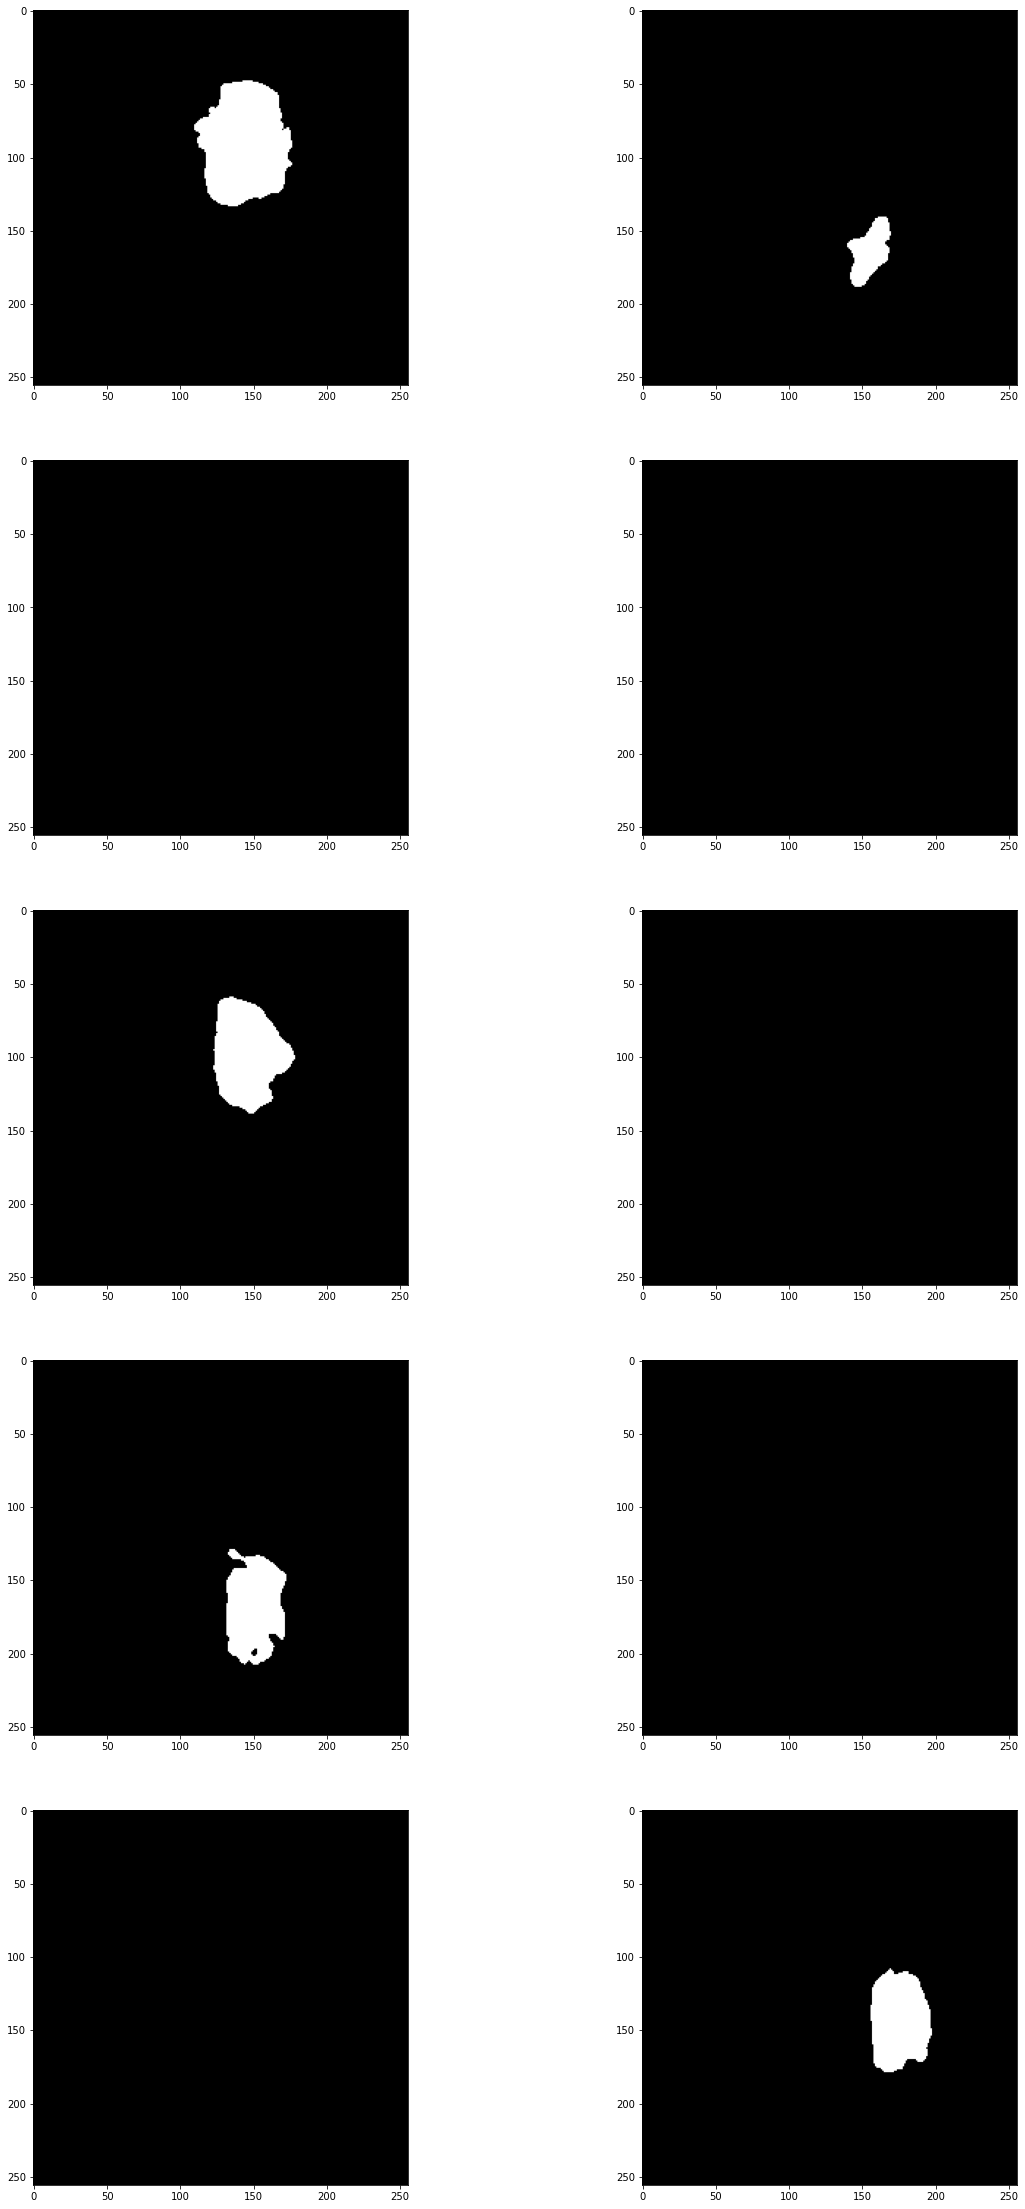

In [76]:
plt.figure(figsize=[20,40])
for item in range(10):
    plt.subplot(5,2,item+1)
    prediction=np.squeeze(predictions[item])
    plt.imshow(prediction,cmap='gray')
    

In [71]:
label_preds=[]
for item in range(len(predictions)):
    if np.max(predictions[item])==1:
        label_preds.append(1)
    else:
        label_preds.append(0)

In [73]:
from sklearn.metrics import accuracy_score
score_transfer=accuracy_score(label_preds,true_labels)
print('The accuracy of model trained using ResNet50 combined with U-Net architecture is :{}'.format(score_transfer))

The accuracy of model trained using ResNet50 combined with U-Net architecture is :0.9694656488549618


# Conclusions

1.Using U-Net type encoder-decoder with skip connections,we obtained an accuracy of 0.8905852417302799 or 89%.

2.Using ResNet50 layers according to U-Net architecture, the model performance significantly increased to an accuracy of 0.9694656488549618 or about 97%.

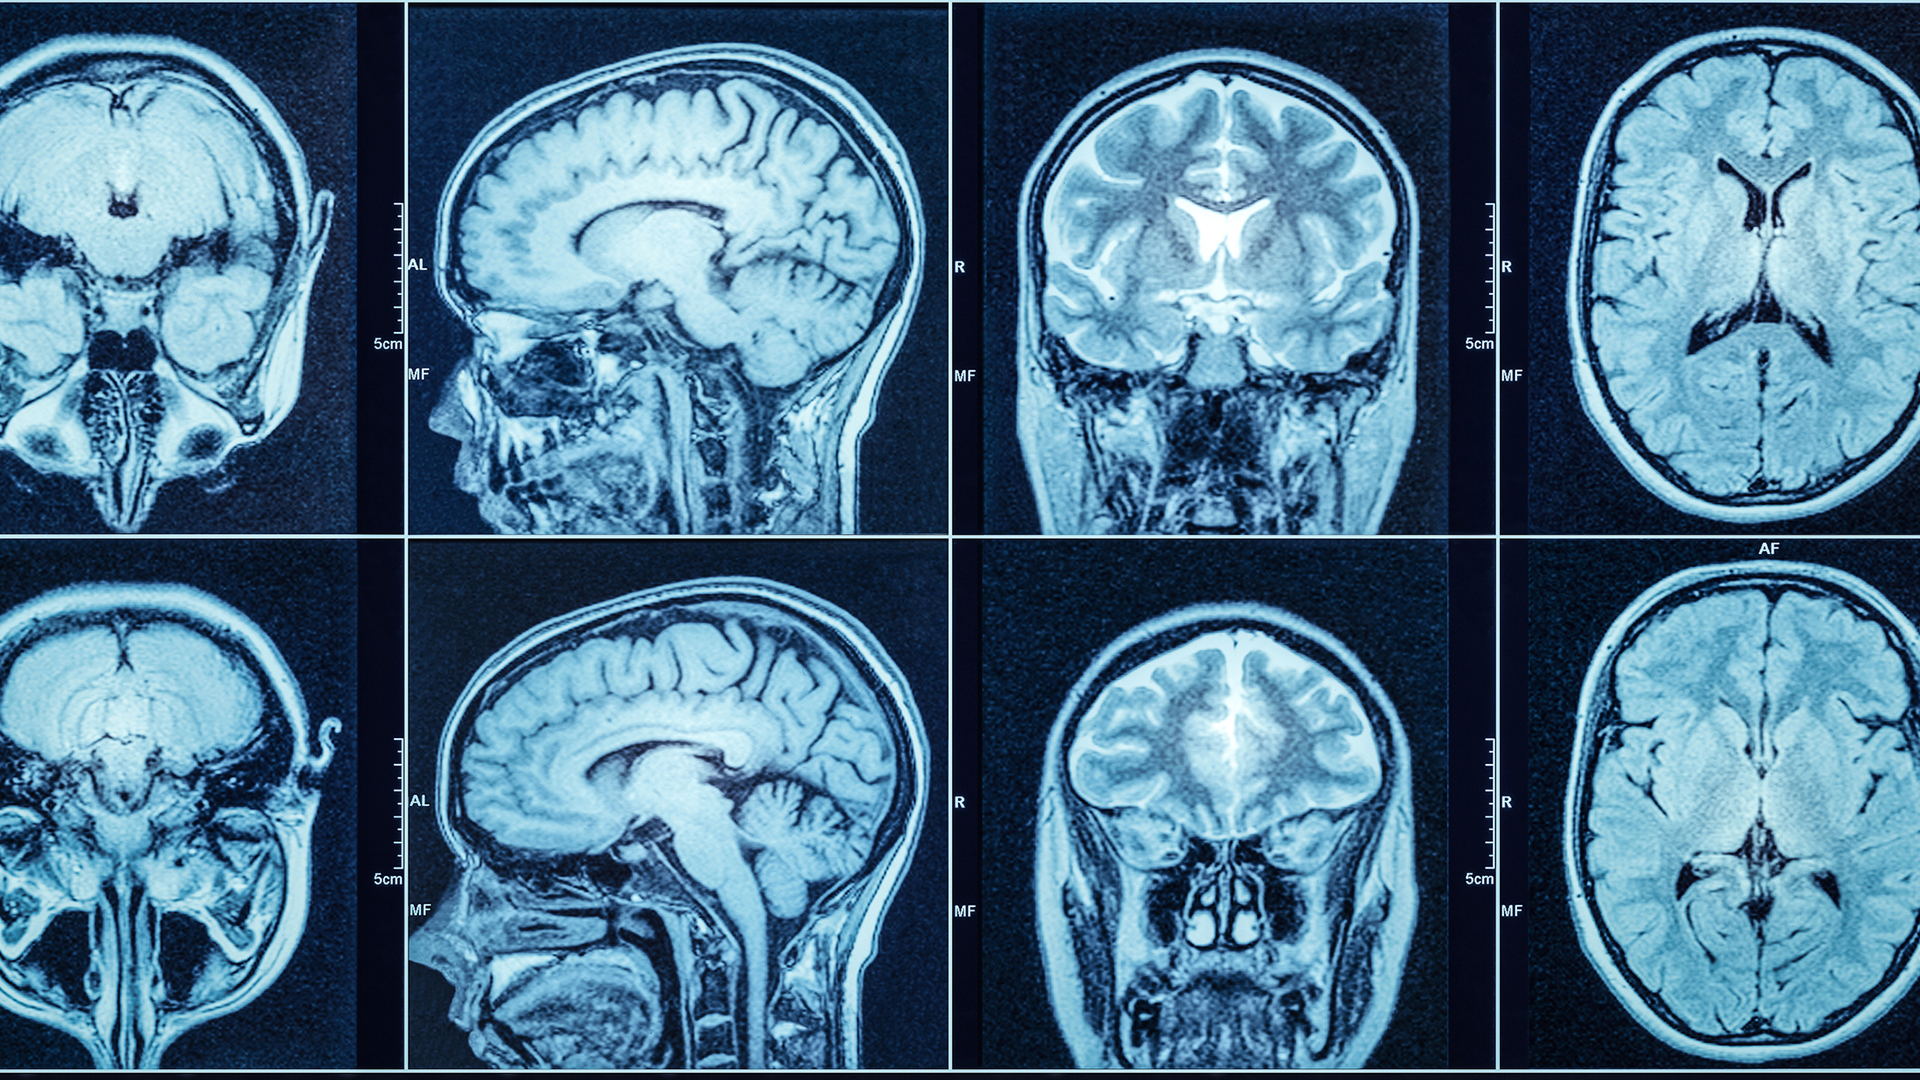

***Source : https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.healtheuropa.eu%2Fextending-the-reach-of-mri-with-new-portable-brain-imaging-scanner%2F104143%2F&psig=AOvVaw1aYrZF4ca6WCRtsazyarKu&ust=1644250938138000&source=images&cd=vfe&ved=0CAsQjRxqFwoTCPjl1Jy-6_UCFQAAAAAdAAAAABAS ***